# Survival impact of InstaPrism cell-type fractions in Schildkraut HGSOC

In [1]:
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import k_fold_cross_validation
from sklearn.model_selection import ParameterGrid
import numpy as np, pandas as pd
from lifelines.utils import k_fold_cross_validation
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid, KFold
import os 
from sklearn.preprocessing import StandardScaler
from matplotlib_venn import venn2
import sys 

sys.path.insert(1, '../../')
sys.path.insert(1, '../')
sys.path.insert(1, '../../../')

import src.hp as hp

pd.set_option("display.max_rows", 100)
plt.style.use('default')

np.random.seed(88)

In [2]:
cell_types_to_use = ["Adipocytes"] # Adipocytes, Stromal, Immune, Epithelial

complete_case =  True

In [3]:
map_stage = True
remove_unknown_stage = True
remove_999_BMI = True
kaplan_meier = True
remove_BMI_treat=False

### Formatting for below plots, etc.

In [4]:
if complete_case:
    remove_treatment = False
    remove_pts_with_unknowns= True
    title_for_plot = f"{cell_types_to_use[0]}: Complete Case Model (n=268)"

else:
    remove_treatment = True
    remove_pts_with_unknowns= False
    title_for_plot = f"{cell_types_to_use[0]}: Reduced Covariate Model (n=566)"

In [5]:
## The order for the plots below
if remove_BMI_treat:
    desired_order = [
        'Age',
        'No Adj Tx.',
        'Race: Black',
        'Residual: < 1cm',
        'Residual: ≥ 1cm',
        'Residual: Unknown size',
    ]
else:
    desired_order = [
        'Age',
        'BMI',
        'No Adj Tx.',
        'Race: Black',
        'Residual: < 1cm',
        'Residual: ≥ 1cm',
        'Residual: Unknown size',
    ]
if remove_treatment:
    desired_order.remove('No Adj Tx.')
    desired_order.remove('Residual: < 1cm')
    desired_order.remove('Residual: ≥ 1cm')
    desired_order.remove('Residual: Unknown size')
    
desired_order

['Age',
 'BMI',
 'No Adj Tx.',
 'Race: Black',
 'Residual: < 1cm',
 'Residual: ≥ 1cm',
 'Residual: Unknown size']

## Load InstaPrism cell-fraction tables (processed) and metadata

Proportions

In [6]:
base_path = os.path.dirname(os.getcwd())
meta_path = os.path.join(base_path, "input_data/metadata.xlsx") 

In [7]:
props = pd.read_csv(os.path.join(base_path, "input_data/proportions_sch.csv"), index_col=0)
props

,SampleID,Plasma cells,B cells,Endothelial cells,T cells,Monocytes,Fibroblasts,NK cells,Epithelial cells,DC,pDC,ILC,Macrophages,Mast cells,Erythroid,Adipocytes,Dataset,suid,ID
0,18341X10,4.919765e-49,0.052767,0.029870,1.833554e-26,1.727071e-60,7.074672e-105,8.375315e-10,0.746341,1.257780e-139,3.590420e-30,2.867046e-78,1.185148e-02,1.538137e-57,0.0,0.159171,SchildkrautB,18341X10,45369
1,18341X12,9.351753e-92,0.027159,0.011666,5.972580e-66,2.258210e-157,8.180384e-107,8.135649e-61,0.848153,3.276474e-210,2.054386e-103,1.247009e-85,2.337775e-128,1.452291e-115,0.0,0.113022,SchildkrautB,18341X12,47261
2,18341X13,6.998799e-32,0.014663,0.041547,1.004614e-23,3.232466e-34,1.225464e-02,9.550579e-19,0.819028,1.104356e-115,3.157063e-69,7.123720e-41,2.994756e-02,1.850941e-63,0.0,0.082561,SchildkrautB,18341X13,47791
3,18341X14,2.410384e-97,0.162711,0.022343,2.056824e-52,5.485488e-33,2.751866e-120,7.904174e-39,0.642545,4.774011e-154,1.326676e-75,2.334007e-77,1.516542e-02,1.488048e-80,0.0,0.157235,SchildkrautB,18341X14,47916
4,18341X15,3.439318e-76,0.050581,0.055021,5.687981e-28,5.314872e-52,8.961526e-02,2.919113e-22,0.649017,7.625379e-122,1.873123e-52,3.487465e-81,1.419715e-02,4.216693e-41,0.0,0.141568,SchildkrautB,18341X15,48002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,20160X95,1.442627e-108,0.136578,0.014420,3.410104e-30,3.267116e-82,7.666630e-23,1.501224e-35,0.710289,6.509988e-151,4.903142e-78,8.571710e-105,3.473745e-03,5.671299e-79,0.0,0.135240,SchildkrautW,20160X95,47786
584,20160X96,1.359916e-92,0.190881,0.017396,5.383974e-33,2.734703e-86,1.156925e-02,1.945285e-24,0.592805,1.063562e-147,5.374615e-82,8.551669e-96,1.270617e-02,4.370517e-04,0.0,0.174205,SchildkrautW,20160X96,47903
585,20160X97,7.862780e-79,0.102850,0.053137,8.610293e-03,1.076987e-46,4.237821e-02,1.467756e-05,0.656171,3.397744e-114,5.089409e-39,1.625064e-79,2.253584e-02,9.865474e-05,0.0,0.114204,SchildkrautW,20160X97,47926
586,20160X98,1.245316e-60,0.127050,0.034344,1.345753e-16,5.846372e-04,2.787547e-02,2.169830e-04,0.673204,4.422809e-95,4.998254e-48,3.881728e-35,5.796692e-04,4.236351e-47,0.0,0.136146,SchildkrautW,20160X98,47937


In [8]:
## Which cell types to use
if cell_types_to_use == ["Immune"]:
    cell_types_to_use_grouped = ["B cells",
                         'Mast cells',
                        'T cells',
                        'Monocytes',
                        'Plasma cells',
                        "NK cells", 
                        "DC",
                        "pDC",  
                        "Macrophages", 
                        "ILC"]
    desired_order = desired_order + ['Immune']

elif cell_types_to_use == ["Stromal"]:
    cell_types_to_use_grouped = ["Fibroblasts",
                         'Endothelial cells']
    desired_order = desired_order + ['Stromal']

elif cell_types_to_use == ["Adipocytes"]:
    cell_types_to_use_grouped = ["Adipocytes"]
    desired_order = desired_order + ['Adipocytes']

elif cell_types_to_use == ["Epithelial"]:
    props["Epithelial"] = props["Epithelial cells"]
    cell_types_to_use_grouped = ["Epithelial"]
    desired_order = desired_order + ['Epithelial']

props[cell_types_to_use[0]] = props[cell_types_to_use_grouped].sum(axis=1)

props[cell_types_to_use[0]] = props[cell_types_to_use[0]] * 10

props

,SampleID,Plasma cells,B cells,Endothelial cells,T cells,Monocytes,Fibroblasts,NK cells,Epithelial cells,DC,pDC,ILC,Macrophages,Mast cells,Erythroid,Adipocytes,Dataset,suid,ID
0,18341X10,4.919765e-49,0.052767,0.029870,1.833554e-26,1.727071e-60,7.074672e-105,8.375315e-10,0.746341,1.257780e-139,3.590420e-30,2.867046e-78,1.185148e-02,1.538137e-57,0.0,1.591710,SchildkrautB,18341X10,45369
1,18341X12,9.351753e-92,0.027159,0.011666,5.972580e-66,2.258210e-157,8.180384e-107,8.135649e-61,0.848153,3.276474e-210,2.054386e-103,1.247009e-85,2.337775e-128,1.452291e-115,0.0,1.130216,SchildkrautB,18341X12,47261
2,18341X13,6.998799e-32,0.014663,0.041547,1.004614e-23,3.232466e-34,1.225464e-02,9.550579e-19,0.819028,1.104356e-115,3.157063e-69,7.123720e-41,2.994756e-02,1.850941e-63,0.0,0.825608,SchildkrautB,18341X13,47791
3,18341X14,2.410384e-97,0.162711,0.022343,2.056824e-52,5.485488e-33,2.751866e-120,7.904174e-39,0.642545,4.774011e-154,1.326676e-75,2.334007e-77,1.516542e-02,1.488048e-80,0.0,1.572353,SchildkrautB,18341X14,47916
4,18341X15,3.439318e-76,0.050581,0.055021,5.687981e-28,5.314872e-52,8.961526e-02,2.919113e-22,0.649017,7.625379e-122,1.873123e-52,3.487465e-81,1.419715e-02,4.216693e-41,0.0,1.415675,SchildkrautB,18341X15,48002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,20160X95,1.442627e-108,0.136578,0.014420,3.410104e-30,3.267116e-82,7.666630e-23,1.501224e-35,0.710289,6.509988e-151,4.903142e-78,8.571710e-105,3.473745e-03,5.671299e-79,0.0,1.352398,SchildkrautW,20160X95,47786
584,20160X96,1.359916e-92,0.190881,0.017396,5.383974e-33,2.734703e-86,1.156925e-02,1.945285e-24,0.592805,1.063562e-147,5.374615e-82,8.551669e-96,1.270617e-02,4.370517e-04,0.0,1.742051,SchildkrautW,20160X96,47903
585,20160X97,7.862780e-79,0.102850,0.053137,8.610293e-03,1.076987e-46,4.237821e-02,1.467756e-05,0.656171,3.397744e-114,5.089409e-39,1.625064e-79,2.253584e-02,9.865474e-05,0.0,1.142044,SchildkrautW,20160X97,47926
586,20160X98,1.245316e-60,0.127050,0.034344,1.345753e-16,5.846372e-04,2.787547e-02,2.169830e-04,0.673204,4.422809e-95,4.998254e-48,3.881728e-35,5.796692e-04,4.236351e-47,0.0,1.361460,SchildkrautW,20160X98,47937


In [9]:
# ─────────────────────────────────────────────────────────────────────────
#  We'll scale the proportions to improve convergence of the Cox model.
#  This is not strictly necessary, but it can help with numerical stability.
# ─────────────────────────────────────────────────────────────────────────

keep_cols = cell_types_to_use + ["SampleID", "Dataset", "ID"]
props = props[keep_cols]

## Merge, encode categorical covariates

### Build the analysis table  (clinical + cell fractions)


In [ ]:
renaming = hp.get_variable_renaming()

Metadata

In [11]:
## Importing and renaming metadata
# continuous covariates to keep “as is”
if remove_BMI_treat:
    cont_cols = ["Age"]
else:
    cont_cols = ["Age", "BMI"]

# ------------------------------ clinical columns -----------------
meta_full = (pd.read_excel(meta_path, sheet_name=0)
               .rename(columns=str.strip)
               .rename(columns=renaming))

meta_full = meta_full[renaming.values()]

meta_full["Stage"] = pd.to_numeric(meta_full["Stage"], errors="coerce")

meta_full["Event"] = meta_full["Event"].astype(int)
meta_full["Time-Days"] = meta_full["Time_Yrs"] * 365.22

meta_full

,ID,Age,Event,Time_Yrs,Stage,Race,Debulk,Hispanic,BMI,NeoTx,AdjTx,Residual,Time-Days
0,40143,63,1,8.739220,3,1,2.0,2,23.218229,2.0,1.0,4.0,3191.737824
1,41377,54,1,1.180014,3,1,2.0,2,17.428942,2.0,NaN,3.0,430.964599
2,41387,55,1,11.983573,3,2,1.0,2,45.470350,2.0,1.0,2.0,4376.640495
3,41391,60,1,4.993840,3,1,2.0,2,31.340800,2.0,NaN,3.0,1823.850185
4,41435,59,1,4.057495,3,1,NaN,2,23.922658,NaN,NaN,NaN,1481.878275
...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,310266,40,0,9.702186,3,2,NaN,2,28.349557,NaN,NaN,NaN,3543.432295
584,320012,66,0,11.767760,3,2,2.0,2,37.677475,2.0,1.0,4.0,4297.821147
585,320025,60,1,6.827869,3,2,2.0,2,38.740537,2.0,1.0,3.0,2493.674262
586,320043,57,1,1.553425,3,2,2.0,2,19.854802,2.0,1.0,4.0,567.341754


Filtering samples

In [12]:
meta_full.Hispanic.value_counts(dropna=False)

Hispanic
2     583
1       3
99      2
Name: count, dtype: int64

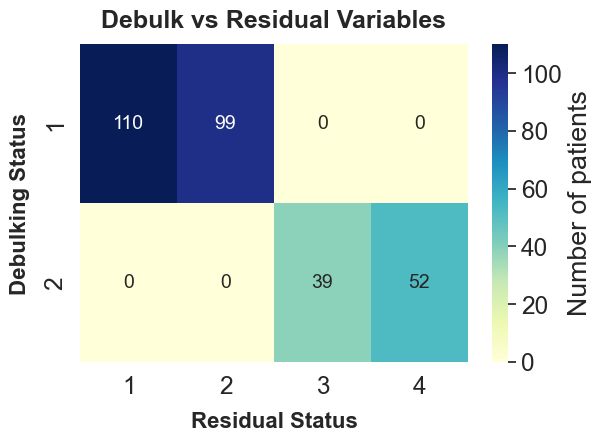

In [13]:
cross_tab = pd.crosstab(meta_full['Debulk'], meta_full['Residual'])
sns.set(style="white", font_scale=1.6)          

ax = sns.heatmap(cross_tab,
                 annot=True,
                 fmt="d",
                 cmap="YlGnBu",
                 annot_kws={"fontsize": 14},
                cbar_kws={"label": "Number of patients"}   
)  

ax.set_title("Debulk vs Residual Variables", fontsize=18, pad=12, fontweight="bold")
ax.set_xlabel("Residual Status", fontsize=16, labelpad=10, fontweight="bold")
ax.set_ylabel("Debulking Status", fontsize=16, labelpad=10, fontweight="bold")
ax.set_xticklabels([1,2,3,4])
ax.set_yticklabels([1,2])
plt.tight_layout()
plt.show()

In [14]:
meta_full["Stage"].value_counts()

Stage
3    469
1     48
2     39
4     23
9      9
Name: count, dtype: int64

In [15]:
meta_full.shape

(588, 13)

In [16]:
if remove_unknown_stage:
    first = meta_full.shape[0]
    meta_full = meta_full[meta_full["Stage"]!=9]
    print("Removed for unknown stage: ",
           first-meta_full.shape[0])

if remove_999_BMI:
    first = meta_full.shape[0]
    meta_full = meta_full[meta_full["BMI"]!=999]
    print("Removed for BMI 999: ",
           first-meta_full.shape[0])

# In no case we'd use Hispanic variable:
meta_full.drop(columns=["Hispanic"], inplace=True)

# We are removing debulking treatment that includes CA125.
meta_full.drop(columns=["Debulk"], inplace=True)

meta_full.drop(columns=["NeoTx"], inplace=True)


meta_full

Removed for unknown stage:  9
Removed for BMI 999:  13


,ID,Age,Event,Time_Yrs,Stage,Race,BMI,AdjTx,Residual,Time-Days
0,40143,63,1,8.739220,3,1,23.218229,1.0,4.0,3191.737824
1,41377,54,1,1.180014,3,1,17.428942,NaN,3.0,430.964599
2,41387,55,1,11.983573,3,2,45.470350,1.0,2.0,4376.640495
3,41391,60,1,4.993840,3,1,31.340800,NaN,3.0,1823.850185
4,41435,59,1,4.057495,3,1,23.922658,NaN,NaN,1481.878275
...,...,...,...,...,...,...,...,...,...,...
583,310266,40,0,9.702186,3,2,28.349557,NaN,NaN,3543.432295
584,320012,66,0,11.767760,3,2,37.677475,1.0,4.0,4297.821147
585,320025,60,1,6.827869,3,2,38.740537,1.0,3.0,2493.674262
586,320043,57,1,1.553425,3,2,19.854802,1.0,4.0,567.341754


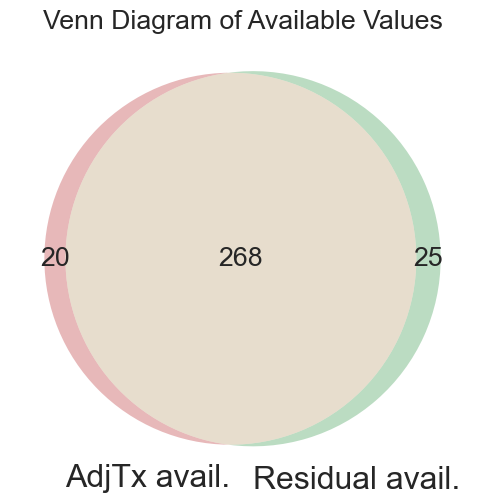

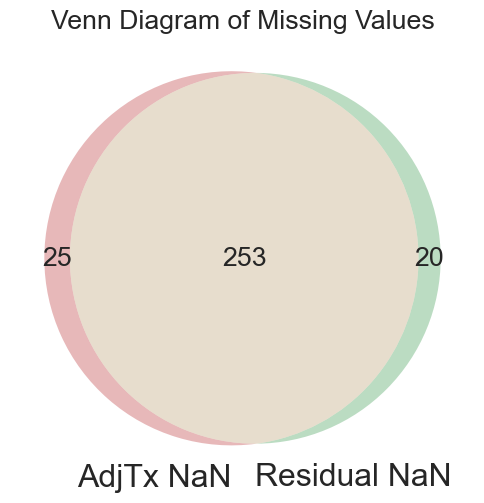

In [17]:
# Assume you already have the DataFrame `meta_full`
# Identify indices (rows) with NaNs in each column
nan_adjtx = set(meta_full[~meta_full['AdjTx'].isna()].index)
nan_residual = set(meta_full[~meta_full['Residual'].isna()].index)

# Create the Venn diagram
plt.figure(figsize=(6,6))
venn2([nan_adjtx, nan_residual], 
      set_labels=('AdjTx avail.', 'Residual avail.'))

plt.title('Venn Diagram of Available Values')
plt.show()

nan_adjtx = set(meta_full[meta_full['AdjTx'].isna()].index)
nan_residual = set(meta_full[meta_full['Residual'].isna()].index)

# Create the Venn diagram
plt.figure(figsize=(6,6))
venn2([nan_adjtx, nan_residual], 
      set_labels=('AdjTx NaN', 'Residual NaN'))

plt.title('Venn Diagram of Missing Values')
plt.show()

In [18]:
# If we remove treatment we only keep Race and Stage of the categoricals.
if remove_treatment:
    cat_cols = ["Stage","Race"]
    meta_full[cat_cols] = meta_full[cat_cols].astype("category")
    meta_full.columns
else:
    cat_cols = ["Stage","Race", "Residual","AdjTx"]
    meta_full[cat_cols] = meta_full[cat_cols].astype("category")
    meta_full.columns


if remove_BMI_treat:
    meta_full.drop(columns=["BMI"], inplace=True)

meta_full

,ID,Age,Event,Time_Yrs,Stage,Race,BMI,AdjTx,Residual,Time-Days
0,40143,63,1,8.739220,3,1,23.218229,1.0,4.0,3191.737824
1,41377,54,1,1.180014,3,1,17.428942,NaN,3.0,430.964599
2,41387,55,1,11.983573,3,2,45.470350,1.0,2.0,4376.640495
3,41391,60,1,4.993840,3,1,31.340800,NaN,3.0,1823.850185
4,41435,59,1,4.057495,3,1,23.922658,NaN,NaN,1481.878275
...,...,...,...,...,...,...,...,...,...,...
583,310266,40,0,9.702186,3,2,28.349557,NaN,NaN,3543.432295
584,320012,66,0,11.767760,3,2,37.677475,1.0,4.0,4297.821147
585,320025,60,1,6.827869,3,2,38.740537,1.0,3.0,2493.674262
586,320043,57,1,1.553425,3,2,19.854802,1.0,4.0,567.341754


In [19]:
# ------------------------------ merge meta + props ----------------------------
# every SampleID maps to a unique suid)
analysis = (props
            .merge(meta_full, on="ID", how="inner"))

print(f"Using: {analysis.shape[0]} rows, {analysis['ID'].nunique()} patients")

analysis

Using: 566 rows, 566 patients


,Adipocytes,SampleID,Dataset,ID,Age,Event,Time_Yrs,Stage,Race,BMI,AdjTx,Residual,Time-Days
0,1.591710,18341X10,SchildkrautB,45369,53,1,2.004107,3,2,31.110562,1.0,3.0,731.939877
1,1.130216,18341X12,SchildkrautB,47261,57,1,5.240246,3,2,29.448927,NaN,NaN,1913.842793
2,0.825608,18341X13,SchildkrautB,47791,45,1,4.396988,3,2,40.981420,NaN,NaN,1605.868090
3,1.572353,18341X14,SchildkrautB,47916,68,1,2.151951,4,2,28.928061,NaN,NaN,785.935442
4,1.415675,18341X15,SchildkrautB,48002,44,1,1.508556,3,2,24.991295,1.0,2.0,550.954743
...,...,...,...,...,...,...,...,...,...,...,...,...,...
561,1.352398,20160X95,SchildkrautW,47786,68,1,2.554415,3,1,31.538819,NaN,NaN,932.923367
562,1.742051,20160X96,SchildkrautW,47903,45,1,2.910335,3,1,20.410354,NaN,NaN,1062.912690
563,1.142044,20160X97,SchildkrautW,47926,52,0,14.414784,3,1,34.458370,NaN,NaN,5264.567555
564,1.361460,20160X98,SchildkrautW,47937,43,1,3.238877,3,1,20.156950,1.0,2.0,1182.902834


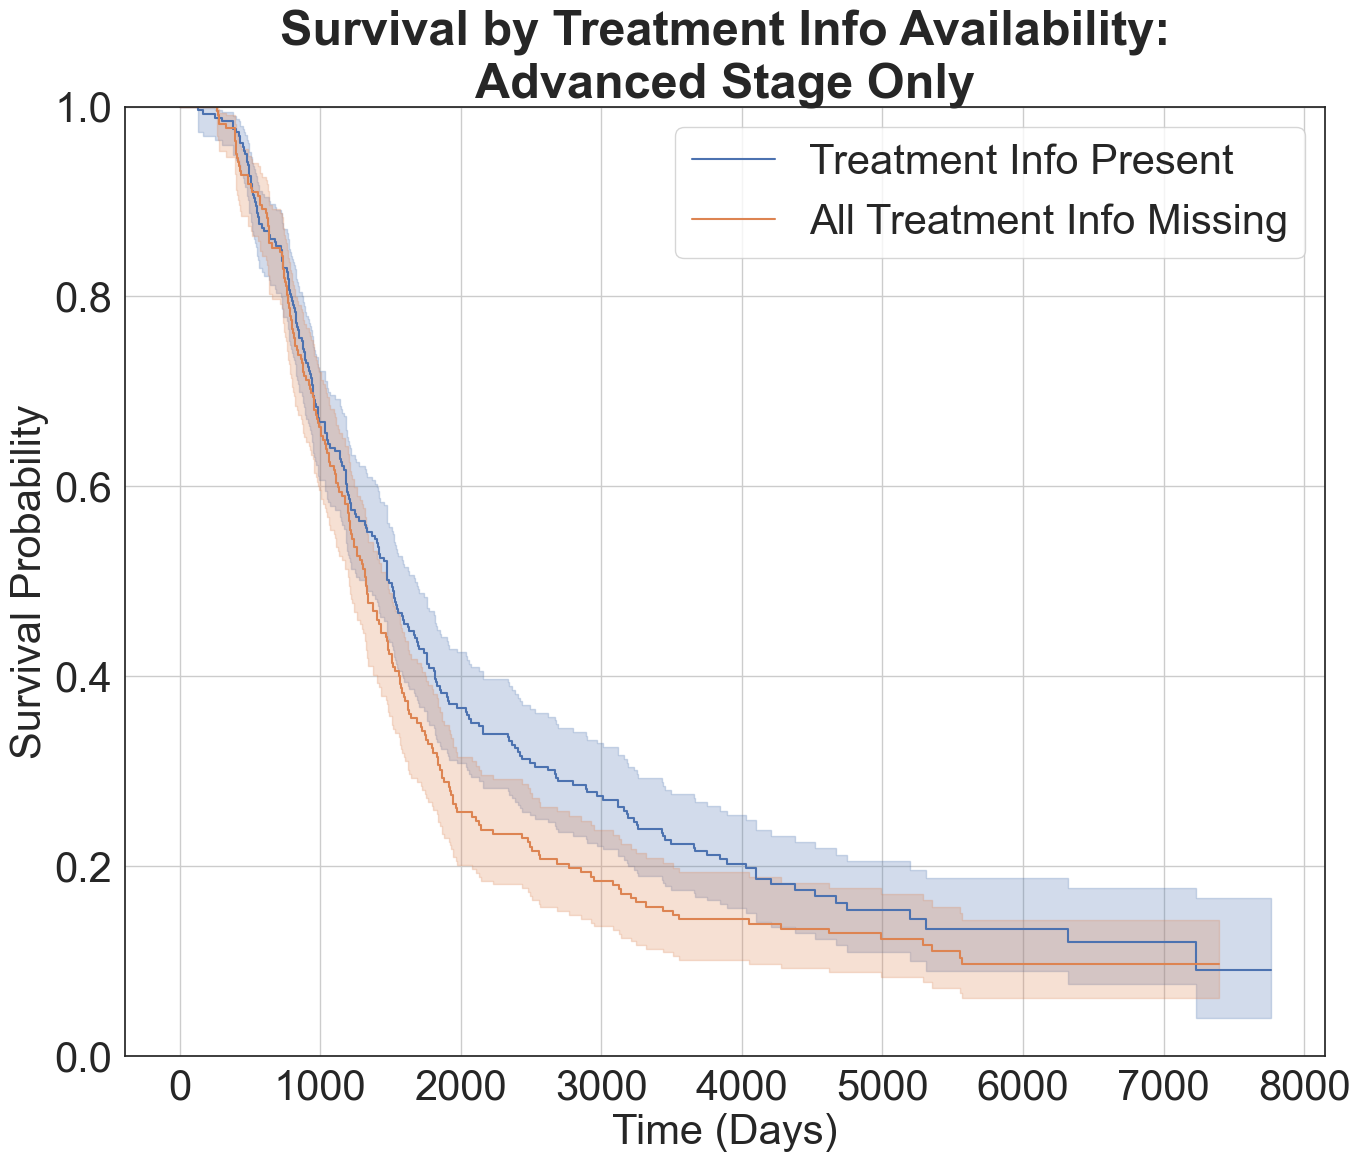

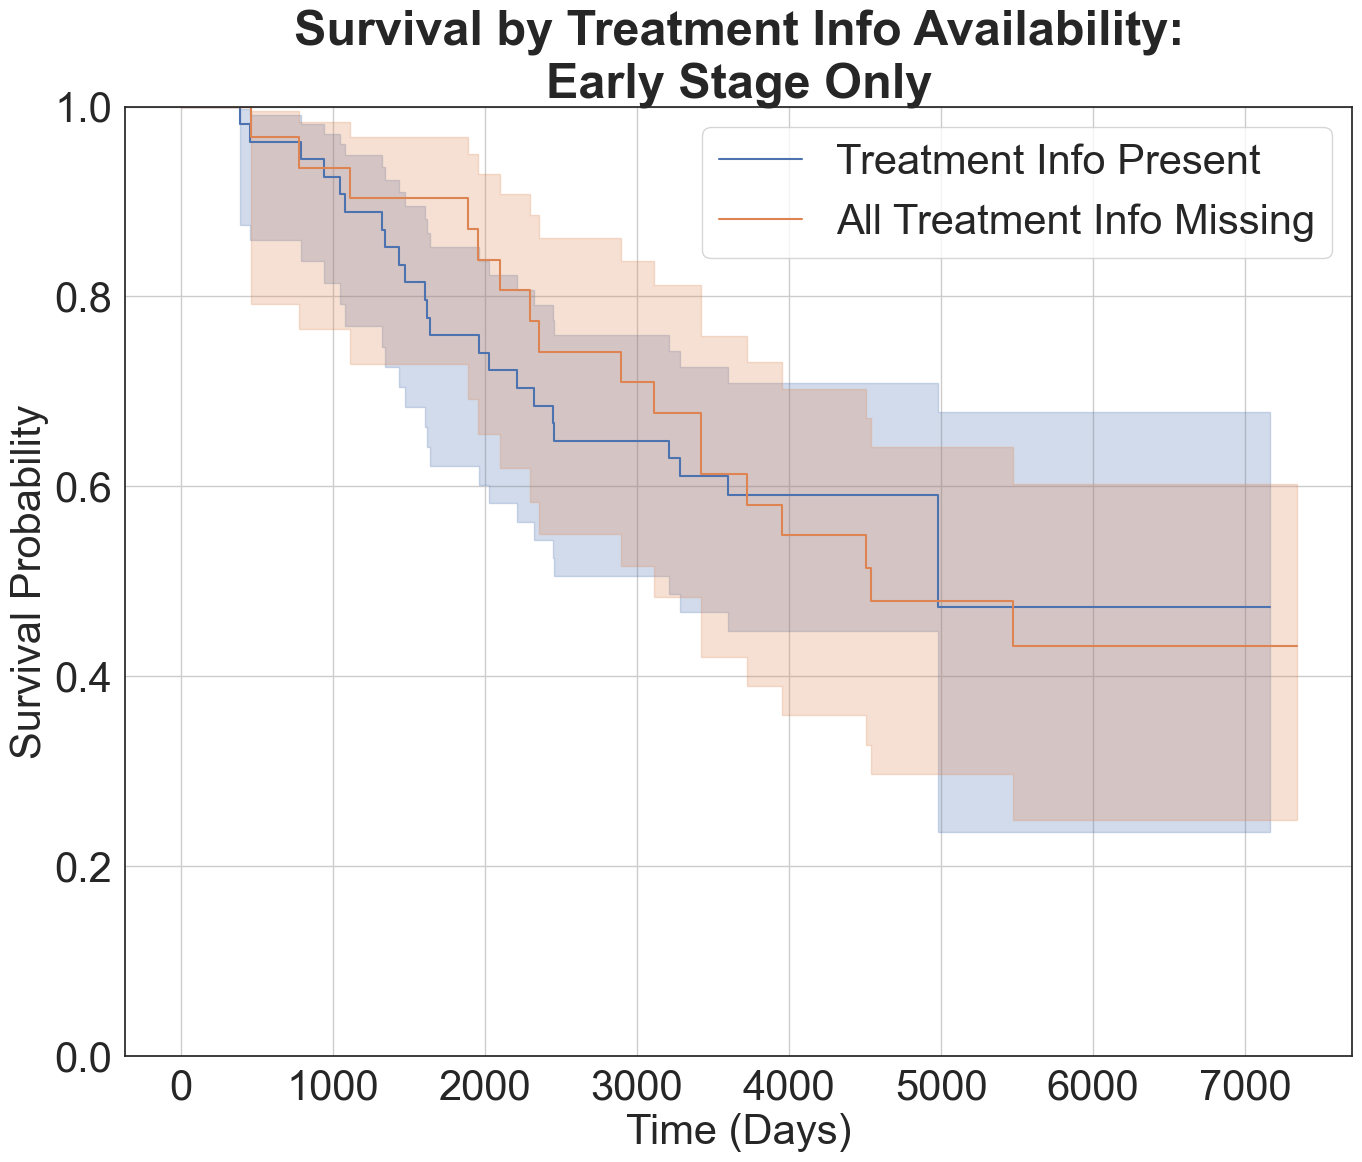

In [20]:
if kaplan_meier := False:
    # Kaplan-Meier survival analysis is not performed
    pass
else:
    # Define treatment columns
    treat_cols = ["AdjTx", "Residual"]

    # Create a new column indicating if all treatment info is missing
    analysis["all_treat_missing"] = analysis[treat_cols].isna().all(axis=1)

    # Define time and event columns (adjust names as needed)
    duration_col = "Time-Days"
    event_col = "Event"

    # Split the data into two groups
    has_info = analysis[~analysis["all_treat_missing"]]
    missing_info = analysis[analysis["all_treat_missing"]]

    hp.plot_km(
        has_info = has_info[has_info.Stage.isin([3, 4])],
        missing_info = missing_info[missing_info.Stage.isin([3, 4])],
        title= "Survival by Treatment Info Availability:\nAdvanced Stage Only", duration_col=duration_col, event_col=event_col
    )

    hp.plot_km(
        has_info = has_info[has_info.Stage.isin([1, 2])],
        missing_info = missing_info[missing_info.Stage.isin([1, 2])],
        title= "Survival by Treatment Info Availability:\nEarly Stage Only", duration_col=duration_col, event_col=event_col
    )
    analysis.drop(columns=["all_treat_missing"], inplace=True)

In [21]:
## Mapping the stage variable for stratification
if map_stage:
    # stage_map = {1: "Early", 2: "Early", 3: "Advanced", 4: "Advanced", 9: "Unknown"}
    # analysis["Stage"] = analysis.Stage.map(stage_map)
    stage_map = {1: 1, 2: 1, 3: 2, 4: 2}
    analysis["Stage"] = analysis.Stage.map(stage_map)

if remove_pts_with_unknowns:
    print("Going from: ",analysis.shape)
    analysis = analysis.dropna(subset=["Residual", "AdjTx"])
    print("To: ", analysis.shape)

analysis

Going from:  (566, 13)
To:  (268, 13)


,Adipocytes,SampleID,Dataset,ID,Age,Event,Time_Yrs,Stage,Race,BMI,AdjTx,Residual,Time-Days
0,1.591710,18341X10,SchildkrautB,45369,53,1,2.004107,2,2,31.110562,1.0,3.0,731.939877
4,1.415675,18341X15,SchildkrautB,48002,44,1,1.508556,2,2,24.991295,1.0,2.0,550.954743
9,2.161446,18341X27,SchildkrautB,46196,67,1,4.635181,2,2,32.198190,1.0,2.0,1692.860945
17,1.816324,18341X35,SchildkrautB,47251,71,1,1.234771,2,2,23.620798,1.0,2.0,450.962957
18,1.298331,18341X38,SchildkrautB,47927,51,1,2.570842,2,2,21.873770,1.0,2.0,938.922875
...,...,...,...,...,...,...,...,...,...,...,...,...,...
556,1.334981,20160X90,SchildkrautW,47148,47,1,1.984942,2,1,39.153028,1.0,3.0,724.940452
557,1.665924,20160X91,SchildkrautW,47185,57,1,11.512663,2,1,43.240248,1.0,2.0,4204.654620
558,1.098901,20160X92,SchildkrautW,47226,71,1,5.577002,2,1,20.892489,1.0,2.0,2036.832690
564,1.361460,20160X98,SchildkrautW,47937,43,1,3.238877,2,1,20.156950,1.0,2.0,1182.902834


In [22]:
for col in analysis:
    print(analysis[col].value_counts(dropna=False))

Adipocytes
1.591710    1
1.438614    1
0.900286    1
1.202717    1
1.174888    1
           ..
1.562868    1
1.300464    1
2.078855    1
3.047693    1
1.484585    1
Name: count, Length: 268, dtype: int64
SampleID
18341X10     1
20160X131    1
20160X115    1
20160X117    1
20160X118    1
            ..
19291X25     1
19291X251    1
19291X252    1
19291X254    1
20160X99     1
Name: count, Length: 268, dtype: int64
Dataset
SchildkrautB    157
SchildkrautW    111
Name: count, dtype: int64
ID
45369     1
48066     1
47209     1
47249     1
47442     1
         ..
43592     1
190009    1
190010    1
190032    1
47991     1
Name: count, Length: 268, dtype: int64
Age
63    13
57    12
61    12
52    11
54    10
67    10
71    10
62    10
56    10
58     9
53     9
55     9
51     9
60     8
72     8
49     7
68     7
73     7
43     7
50     7
66     6
70     6
65     6
69     6
64     6
59     6
46     5
48     5
44     5
45     5
47     5
42     4
74     4
39     3
77     3
41     2
76     

In [23]:
if remove_treatment:
    if remove_BMI_treat:
        cols = ["Age","Event","Time_Yrs","Time-Days","Stage", "Residual","AdjTx"]
    else:
        cols = ["Age","Event","Time_Yrs","BMI","Time-Days","Stage", "Residual","AdjTx"]

    cat_cols = ["Race"]
    # Get dummys for categorical columns with more than 2 cats (NaN counts as category)
    dummies = pd.get_dummies(analysis, columns=cat_cols, drop_first=True, prefix_sep="_")
    dummies.drop(columns=props.columns, inplace=True)  # remove original proportions
    dummies.drop(columns=cols, inplace=True)  # remove original proportions
    dummies

else:
    if remove_BMI_treat:
        cols = ["Age","Event","Time_Yrs","Time-Days","Stage"]
    else:
        cols = ["Age","Event","Time_Yrs","BMI","Time-Days","Stage"]

    cat_cols = ["Residual","AdjTx", "Race"]
    # Get dummys for categorical columns with more than 2 cats (NaN counts as category)
    dummies = pd.get_dummies(analysis, columns=cat_cols, drop_first=True, prefix_sep="_")
    dummies.drop(columns=props.columns, inplace=True)  # remove original proportions
    dummies.drop(columns=cols, inplace=True)  # remove original proportions
dummies

,Residual_2.0,Residual_3.0,Residual_4.0,AdjTx_2.0,Race_2
0,False,True,False,False,True
4,True,False,False,False,True
9,True,False,False,False,True
17,True,False,False,False,True
18,True,False,False,False,True
...,...,...,...,...,...
556,False,True,False,False,False
557,True,False,False,False,False
558,True,False,False,False,False
564,True,False,False,False,False


In [24]:
for col in dummies:
    print(dummies[col].value_counts(dropna=False))

Residual_2.0
False    177
True      91
Name: count, dtype: int64
Residual_3.0
False    235
True      33
Name: count, dtype: int64
Residual_4.0
False    223
True      45
Name: count, dtype: int64
AdjTx_2.0
False    262
True       6
Name: count, dtype: int64
Race_2
True     157
False    111
Name: count, dtype: int64


In [25]:
# Put together the analysis DataFrame
# (keep the original categorical columns for later use)
analysis_enc = pd.concat([analysis,
                        dummies],
                        axis=1)    # Columns that go into the model
cell_cols = props.columns.difference(["SampleID", "Dataset", "ID"])  # fractions
covars = cont_cols  + list(dummies.columns) + list(cell_cols) + ['Stage']
    
covars

['Age',
 'BMI',
 'Residual_2.0',
 'Residual_3.0',
 'Residual_4.0',
 'AdjTx_2.0',
 'Race_2',
 'Adipocytes',
 'Stage']

In [26]:
cox_df = (analysis_enc[["Time-Days", "Event"] + covars]
          .copy())

# and let's make names more interpretable:
if "AdjTx_2.0" in cox_df.columns:
    cox_df.rename(columns={"AdjTx_2.0": "No Adj Tx."}, inplace=True)
if "Race_2" in cox_df.columns:
    cox_df.rename(columns={"Race_2": "Race: Black"}, inplace=True)
if "Residual_4.0" in cox_df.columns:
    cox_df.rename(columns={"Residual_4.0": "Residual: Unknown size"}, inplace=True)
    cox_df.rename(columns={"Residual_3.0": "Residual: ≥ 1cm"}, inplace=True)
    cox_df.rename(columns={"Residual_2.0": "Residual: < 1cm"}, inplace=True)

In [27]:
print("Design matrix:", cox_df.shape)
print("Design matrix columns:", cox_df.columns)
cox_df

Design matrix: (268, 11)
Design matrix columns: Index(['Time-Days', 'Event', 'Age', 'BMI', 'Residual: < 1cm',
       'Residual: ≥ 1cm', 'Residual: Unknown size', 'No Adj Tx.',
       'Race: Black', 'Adipocytes', 'Stage'],
      dtype='object')


,Time-Days,Event,Age,BMI,Residual: < 1cm,Residual: ≥ 1cm,Residual: Unknown size,No Adj Tx.,Race: Black,Adipocytes,Stage
0,731.939877,1,53,31.110562,False,True,False,False,True,1.591710,2
4,550.954743,1,44,24.991295,True,False,False,False,True,1.415675,2
9,1692.860945,1,67,32.198190,True,False,False,False,True,2.161446,2
17,450.962957,1,71,23.620798,True,False,False,False,True,1.816324,2
18,938.922875,1,51,21.873770,True,False,False,False,True,1.298331,2
...,...,...,...,...,...,...,...,...,...,...,...
556,724.940452,1,47,39.153028,False,True,False,False,False,1.334981,2
557,4204.654620,1,57,43.240248,True,False,False,False,False,1.665924,2
558,2036.832690,1,71,20.892489,True,False,False,False,False,1.098901,2
564,1182.902834,1,43,20.156950,True,False,False,False,False,1.361460,2


### Test 25 combinations of penalizer × l1_ratio

Uses 5-fold cross-validation to evaluate model performance

Uses concordance index (a standard survival metric)

Outputs the best parameter set (highest mean_score)

In [28]:
search_grid = {
    "penalizer": [1e-4, 1e-3, 1e-2, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5],
    "l1_ratio":  [0.0]
}

rows, fails = [], []

for p in ParameterGrid(search_grid):
    # create an *unfitted* model with desired penalty
    cph = CoxPHFitter(penalizer=p["penalizer"], l1_ratio=p["l1_ratio"])
    try:
        cidx = k_fold_cross_validation(
            cph,
            cox_df,
            duration_col="Time-Days",
            event_col="Event",
            k=5,
            scoring_method="concordance_index",
            fitter_kwargs={"strata": "Stage"} 
        )
        rows.append({**p,
                     "c_index_mean": np.mean(cidx),
                     "c_index_sd"  : np.std(cidx)})
    except Exception as e:
        fails.append({**p, "error": str(e)})

# ── show best result ────────────────────────────────────────────────────────
if rows:
    cv_res = pd.DataFrame(rows).sort_values("c_index_mean", ascending=False)
    best   = cv_res.iloc[0]
    print("Best parameter set:")
    print(best)
else:
    print("⚠️  All combinations failed.")
    display(pd.DataFrame(fails).head())

/Users/ivicha/anaconda3/envs/env_hgsoc/lib/python3.10/site-packages/lifelines/utils/__init__.py:933: UserWarning: DataFrame Index is not unique, defaulting to incrementing index instead.
  warnings.warn("DataFrame Index is not unique, defaulting to incrementing index instead.")
/Users/ivicha/anaconda3/envs/env_hgsoc/lib/python3.10/site-packages/lifelines/utils/__init__.py:933: UserWarning: DataFrame Index is not unique, defaulting to incrementing index instead.
  warnings.warn("DataFrame Index is not unique, defaulting to incrementing index instead.")
/Users/ivicha/anaconda3/envs/env_hgsoc/lib/python3.10/site-packages/lifelines/utils/__init__.py:933: UserWarning: DataFrame Index is not unique, defaulting to incrementing index instead.
  warnings.warn("DataFrame Index is not unique, defaulting to incrementing index instead.")
/Users/ivicha/anaconda3/envs/env_hgsoc/lib/python3.10/site-packages/lifelines/utils/__init__.py:933: UserWarning: DataFrame Index is not unique, defaulting to incr

Best parameter set:
l1_ratio        0.000000
penalizer       0.000100
c_index_mean    0.609096
c_index_sd      0.039595
Name: 0, dtype: float64


/Users/ivicha/anaconda3/envs/env_hgsoc/lib/python3.10/site-packages/lifelines/utils/__init__.py:933: UserWarning: DataFrame Index is not unique, defaulting to incrementing index instead.
  warnings.warn("DataFrame Index is not unique, defaulting to incrementing index instead.")
/Users/ivicha/anaconda3/envs/env_hgsoc/lib/python3.10/site-packages/lifelines/utils/__init__.py:933: UserWarning: DataFrame Index is not unique, defaulting to incrementing index instead.
  warnings.warn("DataFrame Index is not unique, defaulting to incrementing index instead.")
/Users/ivicha/anaconda3/envs/env_hgsoc/lib/python3.10/site-packages/lifelines/utils/__init__.py:933: UserWarning: DataFrame Index is not unique, defaulting to incrementing index instead.
  warnings.warn("DataFrame Index is not unique, defaulting to incrementing index instead.")
/Users/ivicha/anaconda3/envs/env_hgsoc/lib/python3.10/site-packages/lifelines/utils/__init__.py:933: UserWarning: DataFrame Index is not unique, defaulting to incr

In [29]:
cox_df

,Time-Days,Event,Age,BMI,Residual: < 1cm,Residual: ≥ 1cm,Residual: Unknown size,No Adj Tx.,Race: Black,Adipocytes,Stage
0,731.939877,1,53,31.110562,False,True,False,False,True,1.591710,2
4,550.954743,1,44,24.991295,True,False,False,False,True,1.415675,2
9,1692.860945,1,67,32.198190,True,False,False,False,True,2.161446,2
17,450.962957,1,71,23.620798,True,False,False,False,True,1.816324,2
18,938.922875,1,51,21.873770,True,False,False,False,True,1.298331,2
...,...,...,...,...,...,...,...,...,...,...,...
556,724.940452,1,47,39.153028,False,True,False,False,False,1.334981,2
557,4204.654620,1,57,43.240248,True,False,False,False,False,1.665924,2
558,2036.832690,1,71,20.892489,True,False,False,False,False,1.098901,2
564,1182.902834,1,43,20.156950,True,False,False,False,False,1.361460,2


Iteration 1: norm_delta = 2.39e-01, step_size = 0.9500, log_lik = -953.52570, newton_decrement = 8.53e+00, seconds_since_start = 0.0
Iteration 2: norm_delta = 6.99e-03, step_size = 0.9500, log_lik = -945.24407, newton_decrement = 7.07e-03, seconds_since_start = 0.0
Iteration 3: norm_delta = 3.49e-04, step_size = 0.9500, log_lik = -945.23701, newton_decrement = 1.75e-05, seconds_since_start = 0.0
Iteration 4: norm_delta = 1.16e-08, step_size = 1.0000, log_lik = -945.23700, newton_decrement = 2.56e-14, seconds_since_start = 0.0
Convergence success after 4 iterations.


model,lifelines.CoxPHFitter
duration col,'Time-Days'
event col,'Event'
penalizer,0.5
l1 ratio,0.0
strata,Stage
baseline estimation,breslow
number of observations,268
number of events observed,206
partial log-likelihood,-945.24
time fit was run,2025-08-04 18:43:09 UTC


<Axes: xlabel='log(HR) (95% CI)'>

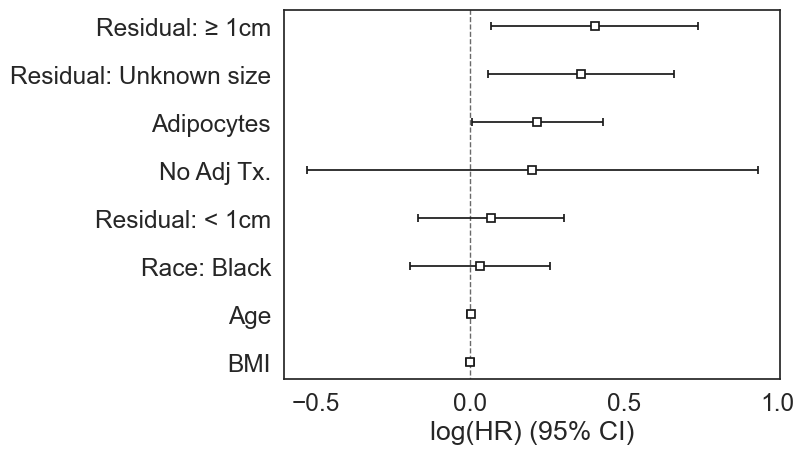

In [30]:
# ------------------------------ fit penalised CoxPH ------------------------------
# cph = CoxPHFitter()
cph_best = CoxPHFitter(penalizer=best.penalizer,
                       l1_ratio=best.l1_ratio)

cph.fit(cox_df, show_progress=True, strata="Stage",
        duration_col="Time-Days",
        event_col="Event")

cph.print_summary(columns=["coef", "exp(coef)", "p", "z"])

cph.plot()

In [31]:
summary_small = (
    cph.summary[["exp(coef)", "p"]]
    .rename(columns={"exp(coef)": "HazardRatio", "p": "P-Value"})
    .reset_index()                         # moves the index into a column
    .rename(columns={"covariate": "Covariate"})  # give that column a nicer name
)
summary_small["Model"] = title_for_plot

new_order = ['Model'] + [c for c in summary_small.columns if c != 'Model']
summary_small = summary_small[new_order]
# take a look
display( summary_small.style.hide(axis="index") )
summary_small.to_clipboard(index=False, excel=True)

Model,Covariate,HazardRatio,P-Value
Adipocytes: Complete Case Model (n=268),Age,1.004454,0.446898
Adipocytes: Complete Case Model (n=268),BMI,1.001325,0.849425
Adipocytes: Complete Case Model (n=268),Residual: < 1cm,1.072140,0.563547
Adipocytes: Complete Case Model (n=268),Residual: ≥ 1cm,1.502213,0.017604
Adipocytes: Complete Case Model (n=268),Residual: Unknown size,1.435596,0.018764
Adipocytes: Complete Case Model (n=268),No Adj Tx.,1.225846,0.585565
Adipocytes: Complete Case Model (n=268),Race: Black,1.033559,0.776234
Adipocytes: Complete Case Model (n=268),Adipocytes,1.246067,0.042328


In [32]:
# Full table
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
Age,0.004444,1.004454,0.005842,-0.007007,0.015895,0.993017,1.016022,0.0,0.760597,0.446898,1.161983
BMI,0.001324,1.001325,0.006976,-0.012348,0.014997,0.987728,1.015110,0.0,0.189852,0.849425,0.235441
Residual: < 1cm,0.069657,1.072140,0.120601,-0.166717,0.306031,0.846439,1.358024,0.0,0.577580,0.563547,0.827391
Residual: ≥ 1cm,0.406939,1.502213,0.171427,0.070949,0.742930,1.073526,2.102086,0.0,2.373834,0.017604,5.827915
Residual: Unknown size,0.361580,1.435596,0.153852,0.060035,0.663124,1.061874,1.940847,0.0,2.350179,0.018764,5.735861
No Adj Tx.,0.203631,1.225846,0.373448,-0.528313,0.935576,0.589599,2.548680,0.0,0.545274,0.585565,0.772099
Race: Black,0.033008,1.033559,0.116131,-0.194604,0.260620,0.823161,1.297734,0.0,0.284230,0.776234,0.365436
Adipocytes,0.219992,1.246067,0.108355,0.007619,0.432365,1.007649,1.540897,0.0,2.030283,0.042328,4.562252


In [33]:
def count_decimal_places(x):
    s = format(x, '.16f').rstrip('0')  # high precision, strip trailing zeros
    if '.' in s:
        return len(s.split('.')[1])
    else:
        return 0

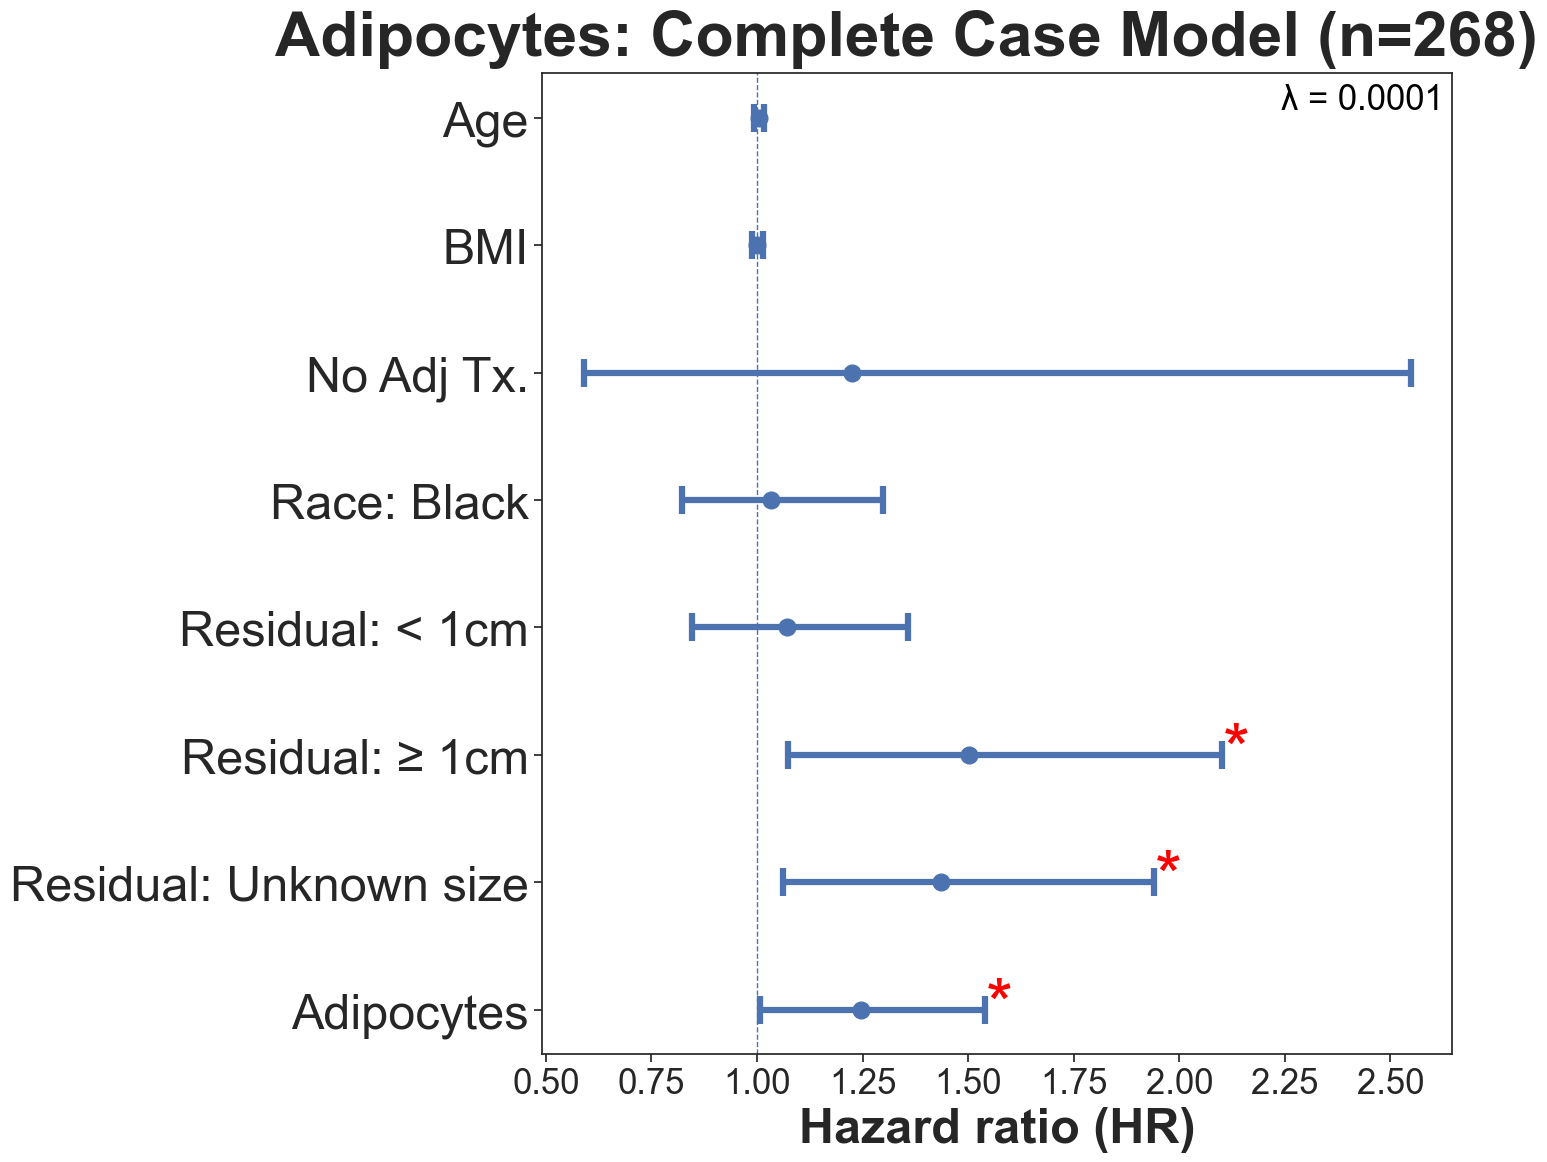

In [34]:
# ------------------------------------------------------------------
# 1. Pull the numbers we need, in a versiofn-agnostic way
# ------------------------------------------------------------------
sns.set_style("ticks", {'xtick.major.size': 5, 'ytick.major.size': 5})
summ = cph.summary.loc[desired_order].copy()

# locate the 95 % CI columns no matter what lifelines called them
ci_lower_col = [c for c in summ.columns if c.startswith("coef lower")][0]
ci_upper_col = [c for c in summ.columns if c.startswith("coef upper")][0]

summ["HR"]      = np.exp(summ["coef"])
summ["lower95"] = np.exp(summ[ci_lower_col])
summ["upper95"] = np.exp(summ[ci_upper_col])

# ------------------------------------------------------------------
# 2. Plot on a *linear* x-axis
# ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(15
                            , 1.5 * len(summ)))
ypos = np.arange(len(summ))

ax.errorbar(
    x=summ["HR"],
    y=ypos,
    xerr=[summ["HR"] - summ["lower95"],
          summ["upper95"] - summ["HR"]],
    fmt="o",
    capsize=10,
    linewidth=4.5, elinewidth=4.5,capthick=4.5, markersize=12
)

ax.axvline(1, ls="--", lw=1)

# mark p < 0.05 covariates with a star
# mark p < 0.05 covariates with a BIG star
for i, p in enumerate(summ["p"]):
    if p < 0.05:
        ax.text(
            summ["upper95"].iloc[i] * 1.001,   
            ypos[i],                         
            "*",                             
            va="center",
            fontsize=50 ,                 
            color="red"            
        )
    if p < 0.005:
        ax.text(
            summ["upper95"].iloc[i] * 1.001,   
            ypos[i],                         
            "**",                             
            va="center",
            fontsize=50,                  
            color="red"            
        )
    if p < 0.0005:
        ax.text(
            summ["upper95"].iloc[i] * 1.001,   
            ypos[i],                         
            "***",                             
            va="center",
            fontsize=50,                  
            color="red"            
        )
    # if p < 0.05:
    #     ax.text(
    #     summ["upper95"].iloc[i]-0.035,   
    #     ypos[i]-0.35,                         
    #     f"p={p:.3f}",                             
    #     va="center",
    #     fontsize=25,                  
    #     color="red",  
    # )
penalizer_decimals =  count_decimal_places(best.penalizer)
if penalizer_decimals > 4: ## If there is more than 4, we'll limit it at 4.
    penal = f"{best.penalizer:.4f}"
else: # Otherwise the full decimals
    penal = f"{best.penalizer}"

ax.text(
    0.99, 0.99,  # (x, y) in axes coordinates (near bottom right)
    f"λ = {penal}",
    transform=ax.transAxes,
    ha="right", va="top",
    fontsize=25,
    color="black"
)

ax.set_yticks(ypos)
ax.set_yticklabels(summ.index, fontsize=35)
plt.xticks(fontsize=25)
ax.set_ylabel("",fontsize=35)
ax.set_xlabel("Hazard ratio (HR)", fontsize=35, fontweight="bold")
ax.set_title(title_for_plot, fontsize=45, fontweight="bold", y=1.01, x=.4)
ax.invert_yaxis()          # top row at the top
plt.tight_layout()
plt.show()

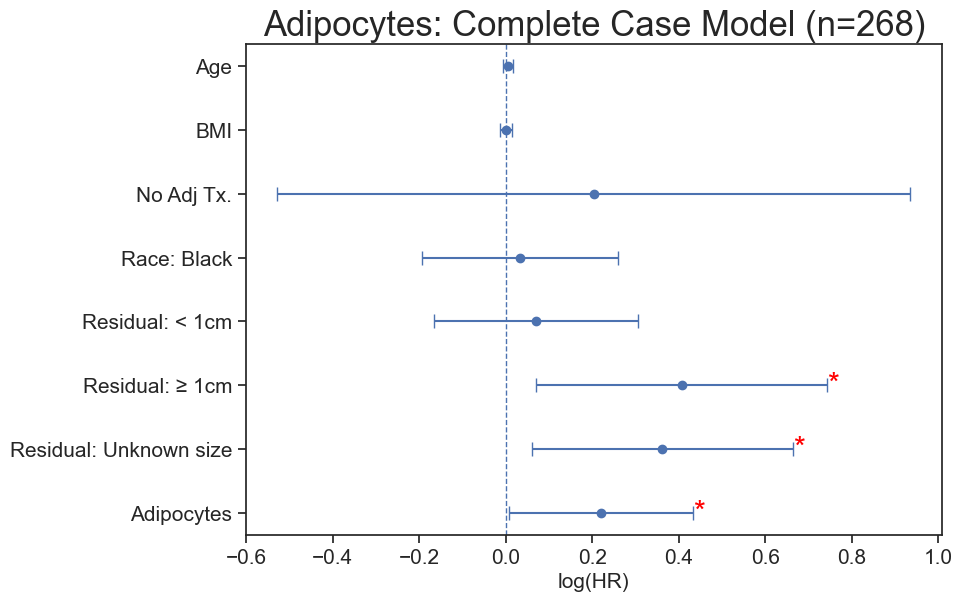

In [35]:
# ------------------------------------------------------------------
# 1. Pull the numbers we need, in a version-agnostic way
# ------------------------------------------------------------------
summ = cph.summary.loc[desired_order].copy()

# locate the 95 % CI columns no matter what lifelines called them
ci_lower_col = [c for c in summ.columns if c.startswith("coef lower")][0]
ci_upper_col = [c for c in summ.columns if c.startswith("coef upper")][0]

# log-scale columns (they’re already logs, but we rename for clarity)
summ["logHR"]      = summ["coef"]
summ["lower95log"] = summ[ci_lower_col]
summ["upper95log"] = summ[ci_upper_col]

# ------------------------------------------------------------------
# 2. Plot on a *linear axis of log-HR*  (0 = HR 1)
# ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 0.8 * len(summ)))
ypos = np.arange(len(summ))

ax.errorbar(
    x=summ["logHR"],
    y=ypos,
    xerr=[summ["logHR"] - summ["lower95log"],
          summ["upper95log"] - summ["logHR"]],
    fmt="o",
    capsize=5,
    linewidth=1.5,
)

# reference line at β = 0  (i.e., HR = 1)
ax.axvline(0, ls="--", lw=1)

# mark p < 0.05 covariates with stars of increasing size / count
for i, p in enumerate(summ["p"]):
    if p < 0.05:
        ax.text(
            summ["upper95log"].iloc[i] + 0.0003,   # small shift right
            ypos[i],
            "*" if p >= 0.005 else "**" if p >= 0.0005 else "***",
            va="center",
            fontsize=22,
            color="red"
        )

# ------------------------------------------------------------------
# 3. Styling
# ------------------------------------------------------------------
ax.set_yticks(ypos)
ax.set_yticklabels(summ.index, fontsize=15)
ax.set_ylabel("")
ax.set_xlabel("log(HR)", fontsize=15)
ax.set_title(title_for_plot, fontsize=25)
plt.xticks(fontsize=15)
ax.invert_yaxis()          # top row at the top
plt.tight_layout()
plt.show()


In [36]:
cph.check_assumptions(cox_df, p_value_threshold=0.05, show_plots=False)

Proportional hazard assumption looks okay.


[]

* **HR > 1** → Higher covariate value is associated with **shorter** survival.  
* **HR < 1** → Higher covariate value is associated with **longer** survival.